### Background
In the field of machine learning, hyperparameter optimization is a critical task that has been studied by numerous researchers. One major challenge in HPO problems is predicting the predictive performance for unknown hyperparameters. In this article, we investigate whether PS-Forest is useful for the HPO performance prediction task and compare it to other algorithms such as XGBoost and Gaussian Process.

### Training Protocol
In our experiment, we first prepare experimental data by randomly sampling 1000 hyperparameter configurations from the HPO-Bench search space, and then we compute the validation score using the HPO-Bench training protocol. The real-world dataset used for training XGBoost is "kr-vs-kp". Our goal is to see if our algorithm can accurately predict the performance of new hyperparameters based on previous hyperparameter optimization data.

In [15]:
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)

data = pd.read_csv('data/XGB_HPO_data.csv', index_col=0)
for c in ['eta', 'min_child_weight', 'reg_alpha', 'reg_lambda']:
    data[c] = np.log(data[c])

x = np.array(data[['colsample_bylevel', 'colsample_bytree', 'eta', 'max_depth',
                   'min_child_weight', 'reg_alpha',
                   'reg_lambda', 'subsample_per_it']])
y = np.array(data['function_value'])

In [16]:
from evolutionary_forest.forest import EvolutionaryForestRegressor
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=0)
basic_primitive = 'add,subtract,multiply,analytical_quotient,protect_sqrt,analytical_loge,maximum'
forest = EvolutionaryForestRegressor(
    max_height=3, normalize=False, select='AutomaticLexicase', boost_size=100,
    basic_primitives=basic_primitive, mutation_scheme='EDA-Terminal-PM',
    semantic_diversity='GreedySelection-Resampling', initial_tree_size='1-2',
    cross_pb=0.9, mutation_pb=0.1, gene_num=10, n_gen=30,
    n_pop=200, base_learner='Fast-RidgeDT'
)

### Important Feature Visualization
First, we train a PS-Forest and plot the feature importance map. Based on this feature importance map, we discover that the maximum value of the minimum child weight (MCW) and the L1 regularization (RA) term is critical in the XGBoost performance prediction task. This is an intriguing discovery because it implies that changing either the MCW or the L1 regularization term could have a similar effect on XGBoost performance. Yet, this is also reasonable because increasing either the MCW or the L1 regularization term reduces the complexity of the final model. However, changing both terms has no effect on the model's complexity.

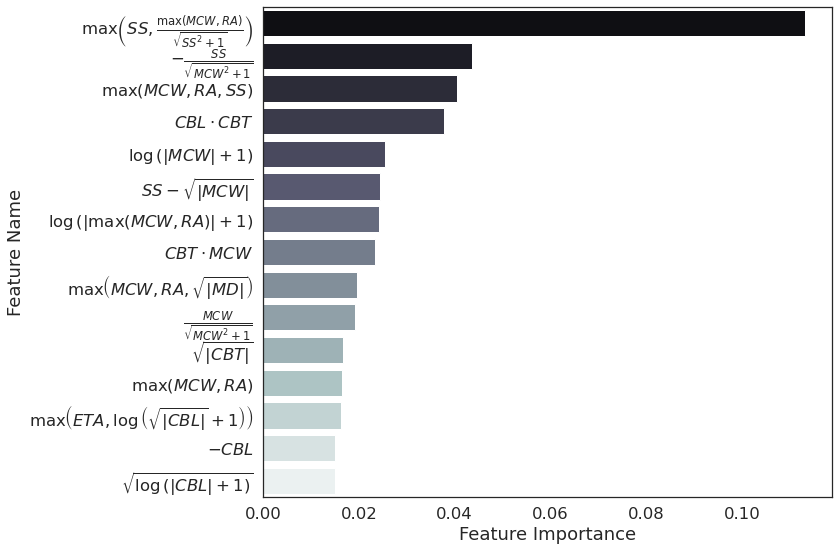

In [17]:
from evolutionary_forest.utils import plot_feature_importance
from evolutionary_forest.utils import get_feature_importance

forest.fit(x, y)

feature_importance_dict = get_feature_importance(forest, simple_version=True)
data_columns = ['CBL', 'CBT', 'ETA', 'MD',
                'MCW', 'RA', 'RL', 'SS']
for k, v in list(feature_importance_dict.items()):
    del feature_importance_dict[k]
    for i in range(len(data_columns) - 1, -1, -1):
        k = k.replace("X_{%d}" % i, data_columns[i])
    feature_importance_dict[k] = v
plot_feature_importance(feature_importance_dict)

### Comparison with Other Algorithms
The preceding result demonstrates that PS-Forest can learn some useful patterns from training data. In this section, we will compare PS-Forest to other cutting-edge algorithms, including XGBoost and Gaussian Process. To simulate the data scarcity scenario in HPO tasks, we perform ten-fold cross-validation, using one-fold as training data and the remaining as testing data, and then plot the distribution of cross-validation score in the figure below. According to the experimental results, PS-Forest is the only learning method capable of achieving a cross-validation score greater than 0.8. This suggests that PS-Forest is a useful tool for HPO performance prediction tasks, and that it may have a wide range of applications in the future.

RPL-Tree [0.64170258 0.68306206 0.57711543 0.68630697 0.65799915 0.66873718
 0.6418345  0.67426168 0.58844961 0.70794888] 0.6527418049326302
RPL-Forest [0.77304643 0.77067059 0.74085149 0.77600934 0.75741606 0.78889955
 0.79454158 0.7640854  0.76128664 0.75964904] 0.7686456116350822
GPR [0.60441354 0.61842619 0.5965659  0.60307009 0.61146479 0.64265741
 0.6442215  0.60734663 0.59550106 0.60374354] 0.6127410643436834
KNN [0.40307839 0.42984449 0.35110984 0.43228673 0.36474937 0.43030923
 0.43906445 0.37649085 0.40301297 0.46318437] 0.4093130692817938
Ridge [0.48210928 0.47745605 0.46552735 0.47902289 0.48270651 0.47266489
 0.50524195 0.4721784  0.47810579 0.46091552] 0.4775928632281466
DT [0.57349885 0.57956597 0.63304949 0.60471995 0.62596868 0.60531528
 0.64683971 0.72472054 0.58585857 0.71289125] 0.6292428289874962
RF [0.81324063 0.76381078 0.79346755 0.76715449 0.7670393  0.79410036
 0.79503334 0.76722965 0.79767944 0.76902567] 0.7827781196468289
ET [0.77230672 0.78074685 0.76414866

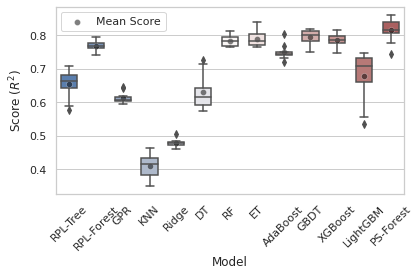

In [18]:
from sklearn.utils.validation import _num_samples
from evolutionary_forest.model.PLTree import RidgeDT
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.utils import indexable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, KFold


class SmallSampleKFold(KFold):
    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        if self.n_splits > n_samples:
            raise ValueError(
                ("Cannot have number of splits n_splits={0} greater"
                 " than the number of samples: n_samples={1}.")
                    .format(self.n_splits, n_samples))

        for train, test in super().split(X, y, groups):
            yield test, train


model_list = {
    'RPL-Tree': RidgeDT(decision_tree_count=2),
    'RPL-Forest': BaggingRegressor(RidgeDT(decision_tree_count=2), n_estimators=100, n_jobs=1),
    'Ridge': Ridge(),
    # 'KR': KernelRidge(kernel='poly'),
    'KNN': Pipeline([
        ('Scaler', StandardScaler()),
        ('KNN', KNeighborsRegressor())
    ]),
    'GPR': Pipeline([
        ('Scaler', StandardScaler()),
        ('GP', GaussianProcessRegressor(kernel=Matern(), normalize_y=True))
    ]),
    'DT': DecisionTreeRegressor(),
    'RF': RandomForestRegressor(n_estimators=100),
    'ET': ExtraTreesRegressor(n_estimators=100),
    'AdaBoost': AdaBoostRegressor(n_estimators=100),
    'GBDT': GradientBoostingRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(n_estimators=100, n_jobs=1),
    'LightGBM': LGBMRegressor(n_estimators=100, n_jobs=1),
    'PS-Forest': EvolutionaryForestRegressor(
        max_height=3, normalize=False, select='AutomaticLexicase', boost_size=100,
        basic_primitives=basic_primitive, mutation_scheme='EDA-Terminal-PM',
        semantic_diversity='GreedySelection-Resampling', initial_tree_size='1-2',
        cross_pb=0.9, mutation_pb=0.1, gene_num=10, n_gen=30,
        n_pop=200, base_learner='Fast-RidgeDT'
    )
}

all_score = []
detailed_score = []
mean_score = []
for model in ['RPL-Tree', 'RPL-Forest', 'GPR', 'KNN', 'Ridge', 'DT',
              'RF', 'ET', 'AdaBoost', 'GBDT', 'XGBoost', 'LightGBM', 'PS-Forest']:
    # score = model_scoring(model, x_test, x_train, y_test, y_train)
    score = cross_val_score(model_list[model], x, y, cv=SmallSampleKFold(10), n_jobs=-1)
    all_score.append((model, np.mean(score), *score))
    for s in score:
        detailed_score.append((model, s))
    mean_score.append((model, np.mean(score)))
    print(model, score, np.mean(score))
detailed_score = pd.DataFrame(detailed_score, columns=['Model', 'Score ($R^2$)'])
mean_score = pd.DataFrame(mean_score, columns=['Model', 'Score'])
print(pd.DataFrame(all_score))
sns.set(style='whitegrid')
sns.boxplot(x="Model", y="Score ($R^2$)", data=detailed_score, showfliers=True, palette='vlag', width=0.6)
sns.scatterplot(x="Model", y="Score", data=mean_score, color='black', alpha=0.5, label='Mean Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()